# 1. Library Import and Device Initialization

**Library Import**:

   - `numpy`: Used for numerical computation and array operations
   - `matplotlib`: Used for data visualization
   - `torch`: PyTorch deep learning framework for neural network models
   - `pyldpc`: Used to generate parity-check and generator matrices for LDPC codes
   - `scipy`: Scientific computing library providing linear algebra tools
   - `torch.utils.data`: PyTorch data loading utilities

**Device Detection**:

   - Prioritizes NVIDIA GPU (CUDA), suitable for large-scale parallel computing
   - Then uses Apple Silicon GPU (MPS), optimized for Mac M-series chips
   - Finally falls back to CPU, ensuring the code runs in any environment

**Device Detection Logic**:
  - `torch.cuda.is_available()`: Detects whether NVIDIA CUDA GPU is available
  - `torch.backends.mps.is_available()`: Detects whether Apple Silicon MPS is available
  - Checks devices in priority order and selects the first available one

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.linalg import inv, LinAlgError
from torch.utils.data import DataLoader, TensorDataset, random_split

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on: NVIDIA GPU (CUDA)")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Running on: Apple Silicon GPU (MPS)")
else:
    device = torch.device("cpu")
    print("Running on: CPU")

# 固定随机种子
seed_val = 42
rng = np.random.RandomState(seed_val)

Running on: Apple Silicon GPU (MPS)


# 2. LDPC Code Loading and Construction

Loading the parity-check matrix H from a standard CCSDS LDPC code Alist format file, then computes the generator matrix G through Gaussian elimination over GF(2). The loaded code is the CCSDS standard (128, 64) code, meaning the code length is 128, the information length is 64, and the code rate is 64/128=0.5. This code is used for subsequent decoding performance testing.

**Error Handling**:

   - Outputs error message if Alist file does not exist
   - Outputs warning and attempts truncation if matrix rank is insufficient
   - Outputs warning when verification fails but does not interrupt program execution

**Parameter Settings**:

   - `MAX_ITER_NMS = 10`: Maximum number of iterations for NMS decoding algorithm
   - `BATCH_SIZE = 512`: Batch size for neural network training
   - `R = k_info / n_code = 64/128 = 0.5`: Code rate


In [ ]:
# --- 1. Alist 文件解析函数 ---
def load_alist(filepath):
    """读取 Alist 格式文件并转换为稀疏矩阵 H"""
    with open(filepath, 'r') as f:
        # 过滤掉注释行和空行
        lines = [line.strip() for line in f if line.strip() and not line.startswith('#')]
    
    # 第一行：矩阵维度 n (列数), m (行数)
    n, m = map(int, lines[0].split())
    # print(f"Reading Alist: n={n}, m={m}")
    
    # 第3, 4行通常是列重和行重信息，跳过
    # Alist 的非零元索引部分从第 5 行开始 (索引为4)
    # 前 n 行是列的非零行索引 (我们通常用不到，直接跳过)
    # 接下来的 m 行是行的非零列索引 (这是构建 H 所需的)
    
    matrix = np.zeros((m, n), dtype=int)
    
    # 定位到描述 Row 的部分。
    # 结构：Header(4行) + n行(Column entries) + m行(Row entries)
    # 注意：有些 Alist 文件可能包含额外的元数据行，这里假设标准格式
    # 如果读取错误，可能需要根据具体文件调整 skip 行数
    
    # 查找数据起始点：跳过前4行 + n行
    start_row_idx = 4 + n 
    
    for i in range(m):
        if start_row_idx + i >= len(lines):
            break
        # 读取第 i 个校验方程连接的变量节点索引
        # Alist 是 1-based 索引，需要减 1 转为 0-based
        # 过滤掉 0 (填充值)
        row_data = lines[start_row_idx + i].split()
        indices = [int(x) - 1 for x in row_data if int(x) > 0]
        
        for col_idx in indices:
            if col_idx < n:
                matrix[i, col_idx] = 1
            
    return matrix

# --- 2. 高斯消元法生成 G 矩阵 (GF2) ---
def get_generator_matrix_dense(H):
    """
    使用高斯消元法从 H (m x n) 计算 G (k x n)。
    1. 对 H 进行列交换和行变换，转化为 [I_m | P] 或 [P | I_m] 形式。
    2. 计算 G = [P.T | I_k] (对应列交换后的顺序)。
    3. 逆向列交换，恢复原始比特顺序。
    """
    m, n = H.shape
    k = n - m
    H_work = H.copy()
    
    # 记录列的排列顺序
    col_order = np.arange(n)
    
    # --- 高斯消元 (转化为 RREF) ---
    pivot_row = 0
    for col in range(n):
        if pivot_row >= m:
            break
            
        # 在当前列 col 中，从 pivot_row 开始寻找非零行
        rows_with_one = np.where(H_work[pivot_row:, col] == 1)[0]
        
        if len(rows_with_one) == 0:
            continue # 该列全为0，跳过（可能是自由变量）
            
        # 找到主元行 (相对于 pivot_row 的偏移)
        pivot_row_offset = rows_with_one[0]
        actual_pivot_row = pivot_row + pivot_row_offset
        
        # 交换行，把主元移到对角线上
        if actual_pivot_row != pivot_row:
            H_work[[pivot_row, actual_pivot_row]] = H_work[[actual_pivot_row, pivot_row]]
            
        # 交换列，把主元列移到左侧 (为了形成 [I | P])
        # 将当前列 col 交换到 pivot_row 位置
        if col != pivot_row:
            H_work[:, [pivot_row, col]] = H_work[:, [col, pivot_row]]
            col_order[[pivot_row, col]] = col_order[[col, pivot_row]]
            
        # 消元：将主元所在列的其他行消为 0
        for r in range(m):
            if r != pivot_row and H_work[r, pivot_row] == 1:
                H_work[r] ^= H_work[pivot_row]
                
        pivot_row += 1
    
    # 此时 H_work 左侧应该是 m x m 的单位矩阵 I (如果满秩)
    # H_sys = [I_m | P], 维度 m x n
    # P 是 m x k
    
    # 检查秩是否满足要求
    if pivot_row < m:
        print(f"Warning: Matrix H is rank deficient. Rank={pivot_row}, m={m}")
        # 这种情况下我们需要截断 H 或调整 k，这里简单处理：保留前 pivot_row 行
        H_work = H_work[:pivot_row, :]
        m = pivot_row
        k = n - m
        
    P = H_work[:, m:] # 取右侧部分 P
    
    # 构造 G_sys = [P.T | I_k]
    # 维度 k x n
    # 注意：对应的 H 列顺序是 [Pivots | Free]，即 [0..m-1 | m..n-1]
    # G * H^T = [P.T | I] * [I | P]^T = P.T + P.T = 0
    
    I_k = np.eye(k, dtype=int)
    G_sys = np.hstack((P.T, I_k))
    
    # --- 恢复列顺序 ---
    # G_sys 对应的是 col_order 的顺序
    # 我们需要构建一个 G，使得 G[:, col_order] = G_sys
    # 即 G[:, original_idx] = G_sys[:, current_col_of_original_idx]
    
    G = np.zeros((k, n), dtype=int)
    # 反向映射：找出 col_order 中每个原始索引的位置
    # col_order[new_pos] = original_pos
    # 所以 G_sys 的第 new_pos 列 对应 原始的第 col_order[new_pos] 列
    
    for new_pos, original_pos in enumerate(col_order):
        G[:, original_pos] = G_sys[:, new_pos]
        
    return G

# --- 3. 执行加载 ---
filename = "CCSDS_ldpc_n128_k64.alist"
print(f"Loading standard CCSDS code from {filename}...")

H_dense = load_alist(filename)
m_check, n_code = H_dense.shape

print(f"H Matrix Loaded: Shape {H_dense.shape}")

print("Constructing Generator Matrix G from H (Gaussian Elimination)...")
G_dense = get_generator_matrix_dense(H_dense)

if G_dense is None:
    raise ValueError("Failed to generate G matrix.")
    
k_info = G_dense.shape[0]
R = k_info / n_code

# 验证 H * G^T = 0
syn_check = (H_dense @ G_dense.T) % 2
if np.any(syn_check != 0):
    print("Warning: G matrix might not satisfy H*G^T=0 exactly. Simulation might be invalid.")
else:
    print("Verification Successful: H @ G.T == 0 (Mod 2)")

# 赋值给全局变量，供后续单元使用
H = H_dense 

print(f"Code Ready: ({n_code}, {k_info}), Rate: {R:.2f}")
print(f"G Matrix Shape: {G_dense.shape}")

# 参数设置保持不变
MAX_ITER_NMS = 12
BATCH_SIZE = 512

Loading standard CCSDS code from CCSDS_ldpc_n128_k64.alist...
H Matrix Loaded: Shape (64, 128)
Constructing Generator Matrix G from H (Gaussian Elimination)...
Verification Successful: H @ G.T == 0 (Mod 2)
Code Ready: (128, 64), Rate: 0.50
G Matrix Shape: (64, 128)


# 3. NMS Implementation

In [ ]:
def decode_nms_trajectory(H, y, snr, max_iter=10, alpha=0.78):
    m, n = H.shape
    rows, cols = H.nonzero()
    var_to_checks = [[] for _ in range(n)]
    check_to_vars = [[] for _ in range(m)]
    for r, c in zip(rows, cols):
        var_to_checks[c].append(r)
        check_to_vars[r].append(c)

    EsNo = 10**(snr / 10.0)
    channel_llr = 4.0 * R * EsNo * y
    
    trajectory = np.zeros((n, max_iter + 1))
    trajectory[:, 0] = channel_llr

    v2c = np.zeros((m, n))
    for v in range(n):
        for c in var_to_checks[v]:
            v2c[c, v] = channel_llr[v]
            
    c2v = np.zeros((m, n))

    for it in range(1, max_iter + 1):
        # Check Node Update
        for c in range(m):
            v_idxs = check_to_vars[c]
            msgs = v2c[c, v_idxs]
            mag = np.abs(msgs)
            sign = np.sign(msgs)
            total_sign = np.prod(sign)
            
            for i, v in enumerate(v_idxs):
                current_mags = np.delete(mag, i)
                min_val = np.min(current_mags) if len(current_mags) > 0 else 0
                my_sign = sign[i] if sign[i] != 0 else 1
                out_sign = total_sign * my_sign
                c2v[c, v] = alpha * out_sign * min_val

        # Variable Node Update
        app_llr = channel_llr + np.sum(c2v, axis=0)
        trajectory[:, it] = app_llr
        
        for v in range(n):
            sum_c = app_llr[v] - channel_llr[v]
            for c in var_to_checks[v]:
                v2c[c, v] = channel_llr[v] + (sum_c - c2v[c, v])
        
        # Syndrome Check
        dec = (app_llr < 0).astype(int)
        syn = (H_dense @ dec) % 2
        if np.all(syn == 0):
            for rest in range(it + 1, max_iter + 1):
                trajectory[:, rest] = app_llr
            return dec, trajectory

    return (trajectory[:, -1] < 0).astype(int), trajectory

# 4. OSD Handling

In [ ]:
def perform_gaussian_elimination(G_matrix, p, k, n):
    """
    对生成矩阵 G (k, n) 的列进行重排，并执行高斯消元，
    使得前 k 列构成单位矩阵 I (Systematic Form)。
    如果前 k 列线性相关，则从后续列中寻找主元并交换。
    
    输入: 
        G_matrix: (k, n) 生成矩阵
        p: 当前的列可靠度排序索引 (长度 n)
    输出:
        G_new: (k, n) 消元后的矩阵，左侧 kxk 为 I
        p_new: 更新后的列索引 (可能发生了列交换)
    """
    # 按可靠度重排 G 的列
    G_work = G_matrix[:, p].copy()
    p_curr = p.copy()
    
    # 开始高斯消元，目标是将 G_work[:, :k] 变为单位矩阵 I
    for r in range(k):
        # 1. 寻找主元 (Pivot)
        # 我们希望主元在 (r, r) 位置。如果 G_work[r, r] == 0，需要交换行或列。
        # 优先在 MRB (前k列) 内部通过行交换解决，保持列（可靠度）顺序不变。
        
        pivot_row = -1
        if G_work[r, r] == 1:
            pivot_row = r
        else:
            # 在当前列 r 的下方寻找非零行
            for i in range(r + 1, k):
                if G_work[i, r] == 1:
                    pivot_row = i
                    break
                    
        # 如果在 MRB 内部找不到主元，说明前 k 列线性相关 (奇异)
        # 必须从 LRB (后 n-k 列) 借一列过来 (列交换)
        if pivot_row == -1:
            found_col = False
            for j in range(k, n): # 在不可靠区域寻找
                # 检查列 j 在行 r 及以下是否有 1
                for i in range(r, k):
                    if G_work[i, j] == 1:
                        # 找到可用的列 j 和 行 i
                        # 1. 交换列 (更新 p 和 G)
                        p_curr[[r, j]] = p_curr[[j, r]]
                        G_work[:, [r, j]] = G_work[:, [j, r]]
                        
                        pivot_row = i
                        found_col = True
                        break
                if found_col:
                    break
            
            if not found_col:
                # 极其罕见：矩阵秩不足 k
                return None, None

        # 2. 行交换 (将 pivot_row 换到第 r 行)
        if pivot_row != r:
            G_work[[r, pivot_row], :] = G_work[[pivot_row, r], :]
            
        # 3. 消元 (将第 r 列的其他行变为 0)
        # 对所有 i != r，如果 G[i, r] == 1，则 Row_i = Row_i XOR Row_r
        cols_to_xor = G_work[:, r] == 1
        cols_to_xor[r] = False # 不处理主元行自己
        if np.any(cols_to_xor):
            G_work[cols_to_xor, :] = G_work[cols_to_xor, :] ^ G_work[r, :]
            
    return G_work, p_curr

def sanitize_input(y):
    """ 增强清洗，防止 Inf/NaN 导致的矩阵运算警告 """
    y = np.nan_to_num(y, nan=0.0, posinf=20.0, neginf=-20.0)
    return np.clip(y, -20.0, 20.0)

def osd_order1_encoding_based(G_work_orig, y_soft, k, n):
    """
    G_work_orig: (k, n)
    """
    y_clean = sanitize_input(y_soft)
    reliability = np.abs(y_clean)
    p = np.argsort(reliability)[::-1]
    
    # 自适应高斯消元
    G_sys, p_new = perform_gaussian_elimination(G_work_orig, p, k, n)
    
    if G_sys is None:
        return (y_clean < 0).astype(int) # Fallback
    
    # 此时 G_sys 的前 k 列是 I。
    # 编码公式 c = u * G_sys. 
    # 因为是系统码形式，信息位 u 就是码字 c 的前 k 位 (在 p_new 排序下)
    
    y_perm = y_clean[p_new]
    r_mrb = (y_perm[:k] < 0).astype(int) # Hard decision on MRB
    
    # Order-1 Test Patterns
    test_patterns = [np.zeros(k, dtype=int)]
    for i in range(k):
        tp = np.zeros(k, dtype=int)
        tp[i] = 1
        test_patterns.append(tp)
        
    best_codeword_perm = None
    min_metric = float('inf')
    
    for pattern in test_patterns:
        # u_try = r_mrb XOR pattern
        u_try = r_mrb ^ pattern
        
        # Encode: c = u * G
        c_try_perm = (u_try @ G_sys) % 2
        
        # Metric: -Sum(s * y) = -Sum((1-2c)*y)
        s_try = 1 - 2 * c_try_perm
        metric = -np.sum(s_try * y_perm)
        
        if metric < min_metric:
            min_metric = metric
            best_codeword_perm = c_try_perm.copy()
            
    # 还原原始顺序
    c_final = np.zeros(n, dtype=int)
    c_final[p_new] = best_codeword_perm
    return c_final

def osd_order2_fast(G_work_orig, y_soft, k, n):
    """
    G_work_orig: (k, n)
    """
    y_clean = sanitize_input(y_soft)
    reliability = np.abs(y_clean)
    p = np.argsort(reliability)[::-1]
    
    G_sys, p_new = perform_gaussian_elimination(G_work_orig, p, k, n)
    
    if G_sys is None:
        return (y_clean < 0).astype(int)

    y_perm = y_clean[p_new]
    r_mrb = (y_perm[:k] < 0).astype(int)
    
    # Order-0 (Base)
    c_base = (r_mrb @ G_sys) % 2
    s_base = 1 - 2 * c_base
    weighted_base = s_base * y_perm
    weighted_base = np.clip(weighted_base, -500.0, 500.0) # Anti-overflow
    
    # Current best correlation
    max_corr = np.sum(weighted_base)
    best_pattern = np.zeros(k, dtype=int) # Pattern is modification on u (MRB)
    
    # G_sys 的每一行对应一个 MRB 位的基向量
    # 翻转 MRB 第 i 位，相当于码字加上 G_sys 的第 i 行 (G_row_i)
    # 增量 Delta_i = Sum_j ( New_Symbol_j * y_j ) - Sum_j ( Old_Symbol_j * y_j )
    # 若 G_ij = 1，符号翻转 (s -> -s)。变化 = -s - s = -2s.
    # Delta_i = Sum_j ( G_ij * (-2 * s_base_j * y_j) ) = -2 * (weighted_base @ G_row_i)
    
    # 计算所有 Order-1 的 Delta
    # (k, n) @ (n, ) -> (k, )
    delta_1 = -2 * (G_sys @ weighted_base)
    
    # --- Order 1 Search ---
    idx_1 = np.argmax(delta_1)
    if max_corr + delta_1[idx_1] > max_corr:
        # 这里只记录局部最优，后面会统一比较
        pass # 逻辑在下面统一处理
        
    # --- Order 2 Search (Top-K Accelerated) ---
    # 只选取 Delta_1 最大的 Top-K 个位置进行 Order-2 组合
    # 这大幅减少了循环次数 (从 67*66/2 = 2211 到 20*19/2 = 190)
    TOP_K = 25 
    top_indices = np.argsort(delta_1)[-TOP_K:]
    
    best_delta_total = 0.0
    
    # 包含 Order-1 的情况 (相当于 Order-2 中第二个索引为空)
    # 检查 Top-K 中的单个翻转是否比当前最好更好
    for idx in top_indices:
        if delta_1[idx] > best_delta_total:
            best_delta_total = delta_1[idx]
            best_pattern = np.zeros(k, dtype=int)
            best_pattern[idx] = 1
            
    # Order-2 Loop
    # Delta(i, j) = Delta(i) + Delta(j) + Correction
    # Correction: 如果 G_ik=1 且 G_jk=1，则第 k 位被翻转两次（即没变）。
    # 简单的 Delta_i + Delta_j 减去了两次 2w (共减4w)，实际应减 0。
    # 所以需加回 4w. Correction = 4 * Sum( w * (G_i & G_j) )
    
    for i in range(len(top_indices)):
        r1 = top_indices[i]
        row1 = G_sys[r1]
        d1 = delta_1[r1]
        
        for j in range(i + 1, len(top_indices)):
            r2 = top_indices[j]
            row2 = G_sys[r2]
            d2 = delta_1[r2]
            
            # 计算重叠修正
            overlap_val = 4 * np.sum(weighted_base * (row1 & row2))
            d_total = d1 + d2 + overlap_val
            
            if d_total > best_delta_total:
                best_delta_total = d_total
                best_pattern = np.zeros(k, dtype=int)
                best_pattern[r1] = 1
                best_pattern[r2] = 1
                
    # 生成最终码字
    # u_final = r_mrb ^ best_pattern
    u_final = r_mrb ^ best_pattern
    c_final_perm = (u_final @ G_sys) % 2
    
    c_final = np.zeros(n, dtype=int)
    c_final[p_new] = c_final_perm
    return c_final

# 5. DIA(CNN) Construction

**Network Architecture**:
  - `nn.Conv1d(1, 16, 3, padding=1)`
  - `nn.Conv1d(16, 8, 3, padding=1)`
  - `nn.Conv1d(8, 4, 3, padding=1)`

**Activation Function**:
  - `ReLU`: `f(x) = max(0, x)`

In [ ]:
class DIA(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv1d(16, 8, 3, padding=1), nn.ReLU(),
            nn.Conv1d(8, 4, 3, padding=1)
        )
        self.fc = nn.Linear(4 * seq_len, 1) 

    def forward(self, x):
        feat = self.conv(x)
        feat = feat.view(feat.size(0), -1)
        return self.fc(feat)

# 6.Fixed SNR Data Generation and Training

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0001, path='dia_model_best.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < (self.best_loss - self.min_delta):
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def get_fixed_snr_data(n_samples, snr_db=2.7):
    print(f"Generating {n_samples} samples at fixed SNR={snr_db} dB...")
    X, Y = [], []
    gen_rng = np.random.RandomState(123)
    count = 0
    
    # G_work is (k, n) now
    G_work = G_dense 
    
    while count < n_samples:
        
        bits = gen_rng.randint(0, 2, k_info) # (k, )
        cw = (bits @ G_work) % 2 # (n, )
        
        s = 1 - 2 * cw
        sigma = np.sqrt(1 / (2 * R * (10**(snr_db/10))))
        y = s + sigma * gen_rng.randn(n_code)
        
        # 使用固定alpha=0.78进行NMS译码
        dec, traj = decode_nms_trajectory(H, y, snr_db, MAX_ITER_NMS, alpha=0.78)
        
        if np.any(dec != cw):
            traj_norm = np.tanh(traj / 2.0)
            # Flatten data: each bit's trajectory is a sample
            for i in range(n_code):
                X.append(traj_norm[i, :])
                Y.append(cw[i])
            count += 1
            if count % 5000 == 0: print(f"  Collected {count} frames...")
            
    return np.array(X), np.array(Y)

# --- 初始化模型与路径 ---
model = DIA(MAX_ITER_NMS + 1).to(device)
MODEL_PATH = "dia_model_best.pth"

if os.path.exists(MODEL_PATH):
    print(f"\n[Info] Pre-trained model found at '{MODEL_PATH}'.")
    print("[Info] Loading model directly... (Skipping training)")
    model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    model.eval()
else:
    print(f"\n[Info] Model '{MODEL_PATH}' not found. Starting Training Loop...")
    TOTAL_SAMPLES = 60000
    FIXED_SNR = 2.7  # 固定SNR值
    X_all, y_all = get_fixed_snr_data(TOTAL_SAMPLES, snr_db=FIXED_SNR)

    full_dataset = TensorDataset(
        torch.from_numpy(X_all).float().unsqueeze(1),
        torch.from_numpy(y_all).float().unsqueeze(1)
    )

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()
    early_stopping = EarlyStopping(patience=5, min_delta=0.0001, path=MODEL_PATH)
    MAX_EPOCHS = 100 

    for epoch in range(MAX_EPOCHS):
        model.train()
        train_loss = 0.0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            out = model(bx)
            loss = criterion(out, by)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for bx, by in val_loader:
                bx, by = bx.to(device), by.to(device)
                out = model(bx)
                loss = criterion(out, by)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f"Epoch {epoch+1}/{MAX_EPOCHS} | Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}", end="")
        
        early_stopping(avg_val_loss, model)
        
        if early_stopping.counter == 0:
            print("  * Best")
        else:
            print(f"  (Patience: {early_stopping.counter}/{early_stopping.patience})")
            
        if early_stopping.early_stop:
            print(f"\nEarly stopping triggered at Epoch {epoch+1}!")
            break
            
    model.load_state_dict(torch.load(MODEL_PATH))
    model.eval()

print("Model is ready for simulation.")


[Info] Model 'dia_model_best.pth' not found. Starting Training Loop...
Generating 60000 samples at fixed SNR=2.7 dB...
  Collected 5000 frames...
  Collected 10000 frames...
  Collected 15000 frames...
  Collected 20000 frames...
  Collected 25000 frames...
  Collected 30000 frames...
  Collected 35000 frames...
  Collected 40000 frames...
  Collected 45000 frames...
  Collected 50000 frames...
  Collected 55000 frames...
  Collected 60000 frames...
Epoch 1/100 | Train Loss: 0.20697 | Val Loss: 0.20694  * Best
Epoch 2/100 | Train Loss: 0.20568 | Val Loss: 0.20489  * Best
Epoch 3/100 | Train Loss: 0.20531 | Val Loss: 0.20510  (Patience: 1/5)
Epoch 4/100 | Train Loss: 0.20521 | Val Loss: 0.20682  (Patience: 2/5)
Epoch 5/100 | Train Loss: 0.20509 | Val Loss: 0.20527  (Patience: 3/5)
Epoch 6/100 | Train Loss: 0.20509 | Val Loss: 0.20457  * Best
Epoch 7/100 | Train Loss: 0.20502 | Val Loss: 0.20451  (Patience: 1/5)
Epoch 8/100 | Train Loss: 0.20497 | Val Loss: 0.20512  (Patience: 2/5)
Epoc

# 7. Simulation & Comparision

In [ ]:
import time

print("\n=== Starting Comprehensive Simulation (NMS vs OSD-1 vs OSD-2) ===")

# 1. SNR 范围设置
snr_range = np.array([2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6, 3.8, 4.0])

# 2. 仿真控制参数
# MAX_FRAMES: 防止在高SNR下仿真时间过长
# MIN_CNN_ERRORS: 确保统计结果的置信度，至少收集50个最难的错误
MAX_FRAMES = 1000000   
MIN_CNN_ERRORS = 50    
SIM_BATCH_SIZE = 1000 

# 3. 结果存储结构 (扩展以包含 OSD-1 的统计)
results = {
    "snr": snr_range,
    "fer": {"nms": [], "std_o1": [], "cnn_o1": [], "std_o2": [], "cnn_o2": []},
    "ber": {"nms": [], "std_o1": [], "cnn_o1": [], "std_o2": [], "cnn_o2": []},
    "time": {"std_o2": [], "cnn_o2": []}
}

# 使用转置后的生成矩阵，适配 OSD 算法的 (k, n) 格式
G_work = G_dense

for snr in snr_range:
    # --- 初始化当前 SNR 的错误计数器 ---
    err_nms = {"fer": 0, "ber": 0}
    err_std1 = {"fer": 0, "ber": 0}
    err_cnn1 = {"fer": 0, "ber": 0}
    err_std2 = {"fer": 0, "ber": 0}
    err_cnn2 = {"fer": 0, "ber": 0}
    
    # 时间统计初始化
    time_stats = {"std_o2": 0.0, "cnn_o2": 0.0, "count": 0}
    
    frames_simulated = 0
    total_bits = 0
    # 计算噪声标准差 sigma
    sigma = np.sqrt(1 / (2 * R * (10**(snr/10))))
    
    start_t = time.time()
    
    print(f"Simulating SNR {snr}dB...", end="", flush=True)
    
    while True:
        n_batch = SIM_BATCH_SIZE
        batch_failed_indices = []
        batch_trajs = []
        batch_y = []
        
        # --- A. NMS 预筛选 (Baseline) ---
        # 首先尝试用快速的 NMS 算法译码
        for _ in range(n_batch):
            # 发送全零码字 (BPSK映射后为 +1.0)
            y_frame = 1.0 + sigma * rng.randn(n_code)
            # NMS 译码
            dec_nms, traj = decode_nms_trajectory(H, y_frame, snr, MAX_ITER_NMS)
            frames_simulated += 1
            total_bits += n_code
            
            # 如果 NMS 失败，则记录下来，交给后续的 OSD 处理
            if np.any(dec_nms != 0): 
                err_nms["fer"] += 1
                err_nms["ber"] += np.sum(dec_nms != 0)
                
                batch_failed_indices.append(len(batch_y))
                # 预处理轨迹数据，用于神经网络输入 (tanh归一化)
                traj_clean = np.nan_to_num(np.tanh(traj / 2.0), nan=0.0)
                batch_trajs.append(traj_clean)
                batch_y.append(y_frame)
        
        # --- B. OSD 处理 (仅针对 NMS 失败帧) ---
        if len(batch_failed_indices) > 0:
            batch_y_np = np.array(batch_y)
            
            # === 1. Standard OSD (标准算法) ===
            for i in range(len(batch_y_np)):
                y_curr = batch_y_np[i]
                
                # Standard OSD-1 (低复杂度)
                res_s1 = osd_order1_encoding_based(G_work, y_curr, k_info, n_code)
                if np.any(res_s1 != 0):
                    err_std1["fer"] += 1
                    err_std1["ber"] += np.sum(res_s1 != 0)

                # Standard OSD-2 (高复杂度) - 记录时间
                t0 = time.perf_counter()
                res_s2 = osd_order2_fast(G_work, y_curr, k_info, n_code)
                time_stats["std_o2"] += (time.perf_counter() - t0)
                
                if np.any(res_s2 != 0):
                    err_std2["fer"] += 1
                    err_std2["ber"] += np.sum(res_s2 != 0)
            
            # === 2. Neural Network 推理 (Batch Processing) ===
            # 将 NMS 轨迹转换为 Tensor
            batch_trajs_np = np.array(batch_trajs)
            inp_tensor = torch.from_numpy(batch_trajs_np).float().unsqueeze(1).to(device)
            
            # 执行推理
            with torch.no_grad():
                n_fails = len(batch_y)
                # Reshape: (batch, 1, seq_len)
                inp_flat = inp_tensor.view(-1, 1, MAX_ITER_NMS + 1)
                logits_flat = model(inp_flat)
                # 获取 CNN 输出的软信息 (取负号适配 LLR 定义)
                cnn_soft_batch = -logits_flat.view(n_fails, n_code).cpu().numpy()
                
            # === 3. Hybrid OSD (混合算法) ===
            for i in range(n_fails):
                y_curr = batch_y_np[i]
                cnn_curr = cnn_soft_batch[i]
                
                # 软信息融合: Channel LLR + CNN Output
                cnn_curr = np.nan_to_num(cnn_curr, nan=0.0, posinf=10.0, neginf=-10.0)
                hybrid_soft = y_curr + (0.78 * cnn_curr)
                
                # Hybrid OSD-1 (CNN增强的低复杂度)
                res_c1 = osd_order1_encoding_based(G_work, hybrid_soft, k_info, n_code)
                if np.any(res_c1 != 0):
                    err_cnn1["fer"] += 1
                    err_cnn1["ber"] += np.sum(res_c1 != 0)

                # Hybrid OSD-2 (CNN增强的高复杂度) - 记录时间
                t0 = time.perf_counter()
                res_c2 = osd_order2_fast(G_work, hybrid_soft, k_info, n_code)
                time_stats["cnn_o2"] += (time.perf_counter() - t0)
                
                if np.any(res_c2 != 0):
                    err_cnn2["fer"] += 1
                    err_cnn2["ber"] += np.sum(res_c2 != 0)
            
            time_stats["count"] += len(batch_y_np)

        # --- C. 停止条件检查 ---
        # 只要最强的算法 (Hybrid OSD-2) 收集到足够的错误，或者总帧数超限，就停止当前 SNR 的仿真
        if err_cnn2["fer"] >= MIN_CNN_ERRORS:
             print(f" -> Stop: Collected {err_cnn2['fer']} Hybrid-OSD2 errors.")
             break
        if frames_simulated >= MAX_FRAMES:
             print(" -> Stop: Reached MAX_FRAMES limit.")
             break
        if frames_simulated % 10000 == 0:
            print(f".", end="", flush=True)
            
    # --- D. 结果保存与打印 ---
    # 计算 FER
    results["fer"]["nms"].append(err_nms["fer"] / frames_simulated)
    results["fer"]["std_o1"].append(err_std1["fer"] / frames_simulated)
    results["fer"]["cnn_o1"].append(err_cnn1["fer"] / frames_simulated)
    results["fer"]["std_o2"].append(err_std2["fer"] / frames_simulated)
    results["fer"]["cnn_o2"].append(err_cnn2["fer"] / frames_simulated)
    
    # 计算 BER
    results["ber"]["nms"].append(err_nms["ber"] / total_bits)
    results["ber"]["std_o2"].append(err_std2["ber"] / total_bits)
    results["ber"]["cnn_o2"].append(err_cnn2["ber"] / total_bits)
    
    # 计算平均耗时 (ms)
    avg_t_std = (time_stats["std_o2"] / time_stats["count"]) * 1000 if time_stats["count"] > 0 else 0
    avg_t_cnn = (time_stats["cnn_o2"] / time_stats["count"]) * 1000 if time_stats["count"] > 0 else 0
    results["time"]["std_o2"].append(avg_t_std)
    results["time"]["cnn_o2"].append(avg_t_cnn)
    
    print(f"\nSNR {snr:.1f}dB | Frames: {frames_simulated}")
    print(f"  FER: NMS {results['fer']['nms'][-1]:.2e}")
    print(f"  FER: S-O1 {results['fer']['std_o1'][-1]:.2e} | C-O1 {results['fer']['cnn_o1'][-1]:.2e}")
    print(f"  FER: S-O2 {results['fer']['std_o2'][-1]:.2e} | C-O2 {results['fer']['cnn_o2'][-1]:.2e}\n")


=== Starting Comprehensive Simulation (NMS vs OSD-1 vs OSD-2) ===
Simulating SNR 2.0dB...

/var/folders/jg/9z84m3897g93c8gcjd_srlv00000gp/T/ipykernel_28865/2508329231.py:163: RuntimeWarning: divide by zero encountered in matmul
  delta_1 = -2 * (G_sys @ weighted_base)
/var/folders/jg/9z84m3897g93c8gcjd_srlv00000gp/T/ipykernel_28865/2508329231.py:163: RuntimeWarning: overflow encountered in matmul
  delta_1 = -2 * (G_sys @ weighted_base)
/var/folders/jg/9z84m3897g93c8gcjd_srlv00000gp/T/ipykernel_28865/2508329231.py:163: RuntimeWarning: invalid value encountered in matmul
  delta_1 = -2 * (G_sys @ weighted_base)


 -> Stop: Collected 79 Hybrid-OSD2 errors.

SNR 2.0dB | Frames: 1000
  FER: NMS 4.55e-01
  FER: S-O1 1.72e-01 | C-O1 9.30e-02
  FER: S-O2 1.36e-01 | C-O2 7.90e-02

Simulating SNR 2.2dB... -> Stop: Collected 86 Hybrid-OSD2 errors.

SNR 2.2dB | Frames: 2000
  FER: NMS 3.56e-01
  FER: S-O1 1.24e-01 | C-O1 5.65e-02
  FER: S-O2 9.75e-02 | C-O2 4.30e-02

Simulating SNR 2.4dB... -> Stop: Collected 57 Hybrid-OSD2 errors.

SNR 2.4dB | Frames: 2000
  FER: NMS 2.97e-01
  FER: S-O1 7.90e-02 | C-O1 3.75e-02
  FER: S-O2 6.80e-02 | C-O2 2.85e-02

Simulating SNR 2.6dB... -> Stop: Collected 55 Hybrid-OSD2 errors.

SNR 2.6dB | Frames: 3000
  FER: NMS 2.06e-01
  FER: S-O1 5.33e-02 | C-O1 2.13e-02
  FER: S-O2 4.53e-02 | C-O2 1.83e-02

Simulating SNR 2.8dB... -> Stop: Collected 56 Hybrid-OSD2 errors.

SNR 2.8dB | Frames: 5000
  FER: NMS 1.55e-01
  FER: S-O1 3.80e-02 | C-O1 1.24e-02
  FER: S-O2 3.04e-02 | C-O2 1.12e-02

Simulating SNR 3.0dB.... -> Stop: Collected 52 Hybrid-OSD2 errors.

SNR 3.0dB | Frames: 

# 8. Plotting

--> Plotting comprehensive comparison charts...
[Info] Using simulation results from memory.


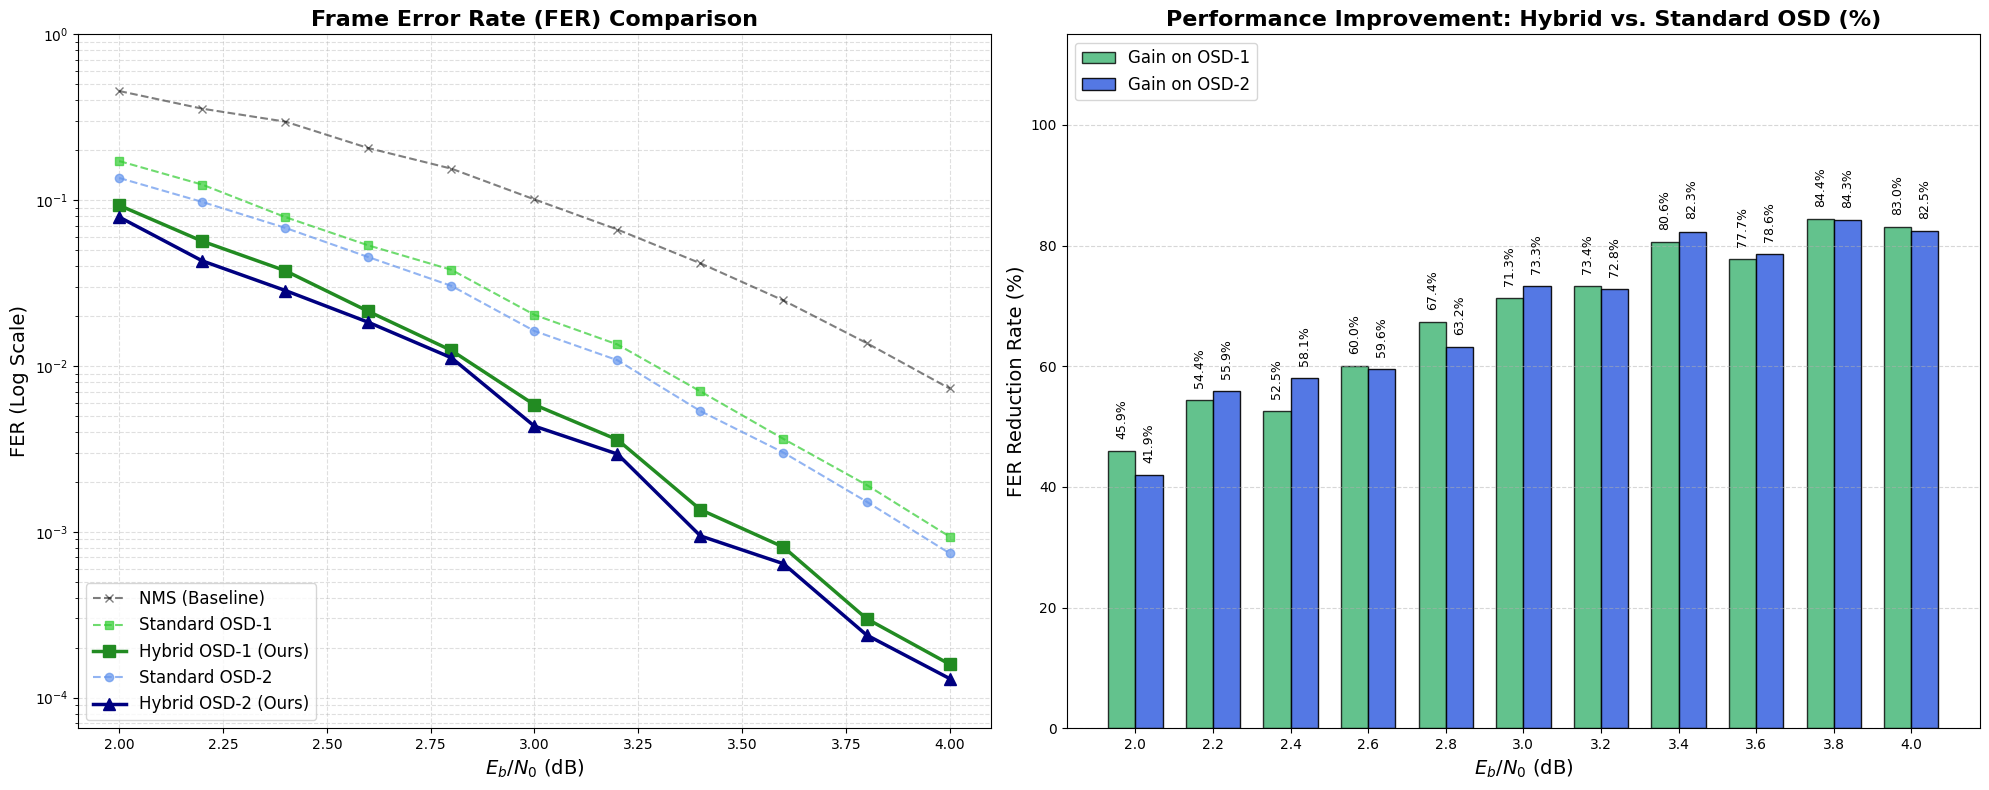


=== Comprehensive Simulation Summary ===
SNR    | Std-O1     Hyb-O1     Gain-O1    | Std-O2     Hyb-O2     Gain-O2   
--------------------------------------------------------------------------------
2.0    | 1.72e-01   9.30e-02   45.9     % | 1.36e-01   7.90e-02   41.9     %
2.2    | 1.24e-01   5.65e-02   54.4     % | 9.75e-02   4.30e-02   55.9     %
2.4    | 7.90e-02   3.75e-02   52.5     % | 6.80e-02   2.85e-02   58.1     %
2.6    | 5.33e-02   2.13e-02   60.0     % | 4.53e-02   1.83e-02   59.6     %
2.8    | 3.80e-02   1.24e-02   67.4     % | 3.04e-02   1.12e-02   63.2     %
3.0    | 2.03e-02   5.83e-03   71.3     % | 1.63e-02   4.33e-03   73.3     %
3.2    | 1.35e-02   3.59e-03   73.4     % | 1.08e-02   2.94e-03   72.8     %
3.4    | 7.02e-03   1.36e-03   80.6     % | 5.34e-03   9.43e-04   82.3     %
3.6    | 3.63e-03   8.08e-04   77.7     % | 3.00e-03   6.41e-04   78.6     %
3.8    | 1.92e-03   2.99e-04   84.4     % | 1.52e-03   2.38e-04   84.3     %
4.0    | 9.35e-04   1.59e-04  

In [ ]:
print("--> Plotting comprehensive comparison charts...")

snr_x = results['snr']
# 提取所有数据
fer_nms = results['fer']['nms']
fer_std1 = results['fer']['std_o1']
fer_hyb1 = results['fer']['cnn_o1']
fer_std2 = results['fer']['std_o2']
fer_hyb2 = results['fer']['cnn_o2']
print("[Info] Using simulation results from memory.")
# -------------------------------------------------------
# 计算相对性能增益 (Percentage Gain)
# -------------------------------------------------------
def calc_gain(std, hyb):
    gains = []
    for f_s, f_h in zip(std, hyb):
        if f_s > 0:
            gains.append((f_s - f_h) / f_s * 100)
        else:
            gains.append(0.0)
    return np.array(gains)

gain_o1 = calc_gain(fer_std1, fer_hyb1)
gain_o2 = calc_gain(fer_std2, fer_hyb2)

# -------------------------------------------------------
# 开始绘图
# -------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# === 图1: FER 性能对比 (5条曲线) ===
# NMS: 黑色虚线
axes[0].semilogy(snr_x, fer_nms, 'k--x', label='NMS (Baseline)', linewidth=1.5, alpha=0.5)

# Order-1: 绿色系
axes[0].semilogy(snr_x, fer_std1, color='limegreen', linestyle='--', marker='s', label='Standard OSD-1', linewidth=1.5, markersize=6, alpha=0.7)
axes[0].semilogy(snr_x, fer_hyb1, color='forestgreen', linestyle='-', marker='s', label='Hybrid OSD-1 (Ours)', linewidth=2.5, markersize=8)

# Order-2: 蓝色系
axes[0].semilogy(snr_x, fer_std2, color='cornflowerblue', linestyle='--', marker='o', label='Standard OSD-2', linewidth=1.5, markersize=6, alpha=0.7)
axes[0].semilogy(snr_x, fer_hyb2, color='navy', linestyle='-', marker='^', label='Hybrid OSD-2 (Ours)', linewidth=2.5, markersize=8)

axes[0].set_title('Frame Error Rate (FER) Comparison', fontsize=16, fontweight='bold')
axes[0].set_xlabel('$E_b/N_0$ (dB)', fontsize=14)
axes[0].set_ylabel('FER (Log Scale)', fontsize=14)
axes[0].grid(True, which="both", ls="--", alpha=0.4)
axes[0].legend(fontsize=12, loc='lower left')
# 调整Y轴显示范围，防止 log 坐标下某些点显示不全
if len(fer_hyb2) > 0:
    min_val = min(min(fer_hyb1), min(fer_hyb2))
    axes[0].set_ylim(bottom=min_val*0.5, top=1.0)

# === 图2: 分组柱状图 (AI Gain on O1 vs O2) ===
# 设计分组
x_indices = np.arange(len(snr_x))
bar_width = 0.35

# 绘制两组柱子
bars1 = axes[1].bar(x_indices - bar_width/2, gain_o1, width=bar_width, 
                   color='mediumseagreen', edgecolor='black', label='Gain on OSD-1', alpha=0.8)
bars2 = axes[1].bar(x_indices + bar_width/2, gain_o2, width=bar_width, 
                   color='royalblue', edgecolor='black', label='Gain on OSD-2', alpha=0.9)

axes[1].set_title('Performance Improvement: Hybrid vs. Standard OSD (%)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('$E_b/N_0$ (dB)', fontsize=14)
axes[1].set_ylabel('FER Reduction Rate (%)', fontsize=14)
axes[1].set_xticks(x_indices)
axes[1].set_xticklabels(snr_x)
axes[1].set_ylim(0, 100)  # 百分比 0-100
axes[1].grid(True, axis='y', ls="--", alpha=0.5)
axes[1].legend(fontsize=12, loc='upper left')

# 标注数值
# 优化后的标注函数：旋转标签以防止重叠
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        # 仅标注大于0的值，保持图表整洁
        if height > 0:
            axes[1].text(bar.get_x() + bar.get_width()/2., height + 2, # 位置稍微上移
                        f'{height:.1f}%',
                        ha='center', va='bottom', 
                        fontsize=9,          # 稍微减小字体
                        rotation=90)         # 关键修改：旋转90度垂直显示

# 建议同时增加Y轴上限，为旋转后的标签留出空间
# 在绘图代码中添加或修改这一行：
axes[1].set_ylim(0, 115)
add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

# -------------------------------------------------------
# 打印综合对比表格
# -------------------------------------------------------
print("\n=== Comprehensive Simulation Summary ===")
print(f"{'SNR':<6} | {'Std-O1':<10} {'Hyb-O1':<10} {'Gain-O1':<10} | {'Std-O2':<10} {'Hyb-O2':<10} {'Gain-O2':<10}")
print("-" * 80)
for i, snr in enumerate(snr_x):
    print(f"{snr:<6.1f} | "
          f"{fer_std1[i]:<10.2e} {fer_hyb1[i]:<10.2e} {gain_o1[i]:<9.1f}% | "
          f"{fer_std2[i]:<10.2e} {fer_hyb2[i]:<10.2e} {gain_o2[i]:<9.1f}%")